<a href="https://colab.research.google.com/github/fatemehabedin2/AIG/blob/main/DL_Transformer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this project, I will design, implement, and evaluate a Transformer-based neural network for a real-world NLP task.

For this purpose, I am going to fune-tune a pre-trained transformer model to predict the Author of the text based on the writing style and context.

# Data Collection and Creating Dataset

I am using nltk.corpus.gutenberg to download 3 books from 3 Author, Jane Austen, G.K. Chesterton and William Shakespeare.


In [ ]:
import nltk
from nltk.corpus import gutenberg
import pandas as pd

# Download corpus if not already
nltk.download('gutenberg')

# Define mapping of author to their available files in the corpus
author_files = {
    "austen": ["austen-emma.txt", "austen-persuasion.txt", "austen-sense.txt"],
    "chesterton": ["chesterton-ball.txt", "chesterton-brown.txt", "chesterton-thursday.txt"],
    "shakespeare": ["shakespeare-caesar.txt", "shakespeare-hamlet.txt", "shakespeare-macbeth.txt"]
}

# Collect text-label pairs
data = []

for author, files in author_files.items():
    for file_id in files:
        # Get raw text
        text = gutenberg.raw(file_id)
        data.append((text, author))

# Wrap into DataFrame
df = pd.DataFrame(data, columns=["text", "author"])

print(df.head(10))
print(df['author'].value_counts())


[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


                                                text       author
0  [Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAP...       austen
1  [Persuasion by Jane Austen 1818]\n\n\nChapter ...       austen
2  [Sense and Sensibility by Jane Austen 1811]\n\...       austen
3  [The Ball and The Cross by G.K. Chesterton 190...   chesterton
4  [The Wisdom of Father Brown by G. K. Chesterto...   chesterton
5  [The Man Who Was Thursday by G. K. Chesterton ...   chesterton
6  [The Tragedie of Julius Caesar by William Shak...  shakespeare
7  [The Tragedie of Hamlet by William Shakespeare...  shakespeare
8  [The Tragedie of Macbeth by William Shakespear...  shakespeare
author
austen         3
chesterton     3
shakespeare    3
Name: count, dtype: int64


In [ ]:
print(gutenberg.raw('austen-emma.txt')[:300])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was t


In [ ]:
print(gutenberg.raw('chesterton-thursday.txt')[:300])

[The Man Who Was Thursday by G. K. Chesterton 1908]

To Edmund Clerihew Bentley

A cloud was on the mind of men, and wailing went the weather,
Yea, a sick cloud upon the soul when we were boys together.
Science announced nonentity and art admired decay;
The world was old and ended: but you and I wer


# Preprocessing (text cleaning) and Chunking
Each Gutenberg file is long (a whole book), so to train a Transformer classifier effectively, we need to split each book into smaller text chunks (e.g., 200–300 words per sample), each labeled with the correct author.

This will:

Help the model generalize better

Provide more training examples

Keep input sizes within the limits of models like BERT

In [ ]:
# check for square bracket content inside each book befor cleaning the title from the book's text
import re
from nltk.corpus import gutenberg

bracket_matches = {}

for author, files in author_files.items():
    for file_id in files:
        text = gutenberg.raw(file_id)
        matches = re.findall(r'\[.*?\]', text)
        if matches:
            bracket_matches[file_id] = matches

for file_id, matches in bracket_matches.items():
    print(f"\n{file_id} - Found {len(matches)} square bracketed items:")
    for match in matches[:10]:
        print(f"  {match}")

# seeing the result I think it is harmless to remove the content in square brackets like [Emma by Jane Austen 1816], because text in square brackets are not very contextual


austen-emma.txt - Found 2 square bracketed items:
  [Emma by Jane Austen 1816]
  [To Mrs. Weston.]

austen-persuasion.txt - Found 1 square bracketed items:
  [Persuasion by Jane Austen 1818]

austen-sense.txt - Found 3 square bracketed items:
  [Sense and Sensibility by Jane Austen 1811]
  [At this point in the first and second editions, Volume 1 ends.]
  [At this point in the first and second edtions, Volume II ended.]

chesterton-ball.txt - Found 13 square bracketed items:
  [The Ball and The Cross by G.K. Chesterton 1909]
  [Employee Identification Number]
  [1]
  [2]
  [1]
  [2]
  [3]
  [1]
  [*]
  [*]

chesterton-brown.txt - Found 1 square bracketed items:
  [The Wisdom of Father Brown by G. K. Chesterton 1914]

chesterton-thursday.txt - Found 1 square bracketed items:
  [The Man Who Was Thursday by G. K. Chesterton 1908]

shakespeare-caesar.txt - Found 3 square bracketed items:
  [The Tragedie of Julius Caesar by William Shakespeare 1599]
  [m]
  [m]

shakespeare-hamlet.txt - Fo

In [ ]:
import re

def clean_text(text):
    # Remove content in square brackets like [Emma by Jane Austen 1816]
    text = re.sub(r'\[.*?\]', '', text)

    # Split into lines before removing \n
    lines = text.split('\n')

    # Remove ALL-CAPS lines and empty lines
    cleaned_lines = [
        line for line in lines
        if not line.strip().isupper() and len(line.strip()) > 0
    ]

    # Join and normalize whitespace
    cleaned_text = " ".join(cleaned_lines)
    return cleaned_text


cleaned_text = clean_text(gutenberg.raw("austen-emma.txt"))
print(cleaned_text[:500])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her. She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.  Her mother had died too long ago for her to have more than an indistinct


In [ ]:
def chunk_cleaned_text(text, chunk_size):
    words = text.split()

    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])

        if len(chunk.split()) >= chunk_size // 2:   # Only keep this chunk if it has at least half the chunk size
            chunks.append(chunk)
    return chunks


In [ ]:
# Creating Final Dataset
chunk_size = 128
chunked_data = []

for _, row in df.iterrows():

    cleaned = clean_text(row["text"])
    chunks = chunk_cleaned_text(cleaned, chunk_size=chunk_size)
    for chunk in chunks:
        chunked_data.append((chunk, row["author"]))

chunked_df = pd.DataFrame(chunked_data, columns=["text", "author"])

print(chunked_df.head())
print(chunked_df['author'].value_counts())


                                                text  author
0  Emma Woodhouse, handsome, clever, and rich, wi...  austen
1  a friend, very fond of both daughters, but par...  austen
2  however, was at present so unperceived, that t...  austen
3  of unexceptionable character, easy fortune, su...  austen
4  their being left to each other, was yet a dear...  austen
author
austen         2812
chesterton     1647
shakespeare     530
Name: count, dtype: int64


# Tokenization with roberta-base

First I need to encode the labels, because classification models don’t understand string labels like "austen", "chesterton", or "shakespeare" directly.

Transformer models expect the labels to be integers so they can compute loss (e.g., using CrossEntropyLoss) and make predictions accordingly.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
chunked_df['label'] = le.fit_transform(chunked_df['author'])

# For reference
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'austen': 0, 'chesterton': 1, 'shakespeare': 2}


In [ ]:
# Prepare the final dataset

from datasets import Dataset, ClassLabel
import pandas as pd

# Create Hugging Face dataset
hf_dataset = Dataset.from_pandas(chunked_df[['text', 'label']])  # we only need relevant columns

# see the label names
label_names = list(le.classes_)
num_labels = len(label_names)
print(num_labels, label_names)

3 ['austen', 'chesterton', 'shakespeare']


In [ ]:
# see some random samples of the dataset
hf_dataset.to_pandas().head()

sampled = hf_dataset.shuffle(seed=42).select(range(5))

for example in sampled:
    print(f"Text:\n{example['text'][:300]}...\nLabel: {example['label']}\n")


Text:
To cut his throat i'th' Church Kin. No place indeed should murder Sancturize; Reuenge should haue no bounds: but good Laertes Will you doe this, keepe close within your Chamber, Hamlet return'd, shall know you are come home: Wee'l put on those shall praise your excellence, And set a double varnish o...
Label: 2

Text:
But perhaps there was something ostentatiously elegant about the languid figure of Seymour leaning against one of the looking-glasses that brought him up short at the entrance, turning his head this way and that like a bewildered bulldog. "I must show this stupid man where to go," said Aurora in a w...
Label: 1

Text:
through the window, but without getting off his horse; and though I told him how ill I was, not one of them have been near me. It did not happen to suit the Miss Musgroves, I suppose, and they never put themselves out of their way." "You will see them yet, perhaps, before the morning is gone. It is ...
Label: 0

Text:
a more relenting heart than she po

I am going to use roberta-base pre-trained model because BERT based models are designed for tasks that require understanding the relationships and representations within text.

After comparing different models in this category, I prefered roberta-base because of the Best accuracy/performance balance.


| Model                                          | Size | Pros                                   | Cons                              | Verdict                               |
| ---------------------------------------------- | ---- | -------------------------------------- | --------------------------------- | ------------------------------------- |
| **`roberta-base`**                             | 125M | Stronger than BERT, better pretraining | Slightly slower than DistilBERT   | Best accuracy/performance balance  |
| **`distilbert-base-uncased`**                  | 66M  | Very fast, GPU-friendly, lower RAM use | Slightly lower accuracy than BERT | Great for quick iteration on Kaggle |
| **`microsoft/deberta-v3-small`**               | 86M  | State-of-the-art for many tasks, small | Slightly slower to load           | Most powerful small model          |
| `bert-base-uncased`                            | 110M | Standard, well-understood              | Not state-of-the-art anymore      | Still a solid baseline                |
| `google/bert_uncased_L-4_H-256_A-4` (TinyBERT) | 14M  | Extremely small and fast               | Lower performance                 | Fastest, but less expressive       |


I am also using roberta-base tokenizer from Hugging Face transformers for tokenization of dataset.


In [ ]:
# Load the roberta-base tokenizer from Hugging Face transformers.
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(row):
    tokens = tokenizer(
        row["text"],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    tokens["label"] = row["label"]
    return tokens


tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
tokenized_dataset[0] # For RoBERTa, the pad_token_id = 1. If text chunk is shorter than 512 tokens, the remaining positions are filled with 1

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

{'text': "Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her. She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period. Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection. Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a governess than",
 'label': 0,
 'input_ids': [0,
  16750,
  1916,
  3132,
  3138,
  6,
  19222,
  6,
  13074,
  6,
  8,
  4066,
  6,
  19,
  10,
  3473,
  184,
  8,
  1372,
  31779,
  6,
  2551,
  7,
  17013,
  103,
  9,
  5,
  275,
  27481,
  9,
  8066,
  131,
  8,
 

In [ ]:
# decoding the tokens
print("Decoded tokens:")
print(tokenizer.convert_ids_to_tokens(tokenized_dataset[0]['input_ids']))

print("Pad token:", tokenizer.pad_token, "with ID:", tokenizer.pad_token_id)

Decoded tokens:
['<s>', 'Em', 'ma', 'ĠWood', 'house', ',', 'Ġhandsome', ',', 'Ġclever', ',', 'Ġand', 'Ġrich', ',', 'Ġwith', 'Ġa', 'Ġcomfortable', 'Ġhome', 'Ġand', 'Ġhappy', 'Ġdisposition', ',', 'Ġseemed', 'Ġto', 'Ġunite', 'Ġsome', 'Ġof', 'Ġthe', 'Ġbest', 'Ġblessings', 'Ġof', 'Ġexistence', ';', 'Ġand', 'Ġhad', 'Ġlived', 'Ġnearly', 'Ġtwenty', '-', 'one', 'Ġyears', 'Ġin', 'Ġthe', 'Ġworld', 'Ġwith', 'Ġvery', 'Ġlittle', 'Ġto', 'Ġdistress', 'Ġor', 'Ġvex', 'Ġher', '.', 'ĠShe', 'Ġwas', 'Ġthe', 'Ġyoungest', 'Ġof', 'Ġthe', 'Ġtwo', 'Ġdaughters', 'Ġof', 'Ġa', 'Ġmost', 'Ġaffection', 'ate', ',', 'Ġindul', 'gent', 'Ġfather', ';', 'Ġand', 'Ġhad', ',', 'Ġin', 'Ġconsequence', 'Ġof', 'Ġher', 'Ġsister', "'s", 'Ġmarriage', ',', 'Ġbeen', 'Ġmistress', 'Ġof', 'Ġhis', 'Ġhouse', 'Ġfrom', 'Ġa', 'Ġvery', 'Ġearly', 'Ġperiod', '.', 'ĠHer', 'Ġmother', 'Ġhad', 'Ġdied', 'Ġtoo', 'Ġlong', 'Ġago', 'Ġfor', 'Ġher', 'Ġto', 'Ġhave', 'Ġmore', 'Ġthan', 'Ġan', 'Ġindist', 'inct', 'Ġremembrance', 'Ġof', 'Ġher', 'Ġca', 'resses', '

In [ ]:
# Second approach: Tokenize without padding

from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(row):        # adds 'input_ids', 'attention_mask' to our dataset
    tokens = tokenizer(
        row["text"],
        truncation=True,
#        padding='max_length',   Tokenize without padding instead I will use DataCollatorWithPadding to pad dynamically per batch which is significantly more efficient
        max_length=512
    )
    tokens["label"] = row["label"]
    return tokens


tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
tokenized_dataset[0]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

{'text': "Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her. She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period. Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection. Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a governess than",
 'label': 0,
 'input_ids': [0,
  16750,
  1916,
  3132,
  3138,
  6,
  19222,
  6,
  13074,
  6,
  8,
  4066,
  6,
  19,
  10,
  3473,
  184,
  8,
  1372,
  31779,
  6,
  2551,
  7,
  17013,
  103,
  9,
  5,
  275,
  27481,
  9,
  8066,
  131,
  8,
 

In [ ]:
len(tokenized_dataset)

4989

In [ ]:
tokenized_dataset.shape

(4989, 4)

In [ ]:
tokenized_dataset.column_names


['text', 'label', 'input_ids', 'attention_mask']

In [ ]:
chunked_df.shape

(4989, 3)

In [ ]:
tokenized_dataset.features
# length=-1 means variable-length sequences, since we are using dynamic padding with a DataCollatorWithPadding

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Splitting Hugging Face Dataset

Using Hugging Face's built-in split

In [ ]:
# First split: 80% train, 20% temp (val + test)
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = train_test_split["train"]
temp_dataset = train_test_split["test"]

# Second split: temp into 50% val, 50% test
val_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42)

val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 3991
Validation size: 499
Test size: 499


In [ ]:
set(train_dataset['label'])  # checking the number of labels

{0, 1, 2}

# training the model

First I will load Pretrained RoBERTa Model for Classification

Then I will Define TrainingArguments



In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "roberta-base"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

2025-08-07 13:43:52.516788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754574232.877669      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754574232.978953      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(         # TrainingArguments object, which later pass into the Trainer and defines how training will happen
    output_dir="./results",           # sets the folder where model checkpoints, logs, and config files will be saved
    eval_strategy="epoch",      # Evaluate the model once at the end of every epoch using the validation set
    save_strategy="epoch",          # Save a checkpoint (i.e., the model) at the end of each epoch
    logging_strategy="epoch",       # Logs training metrics like loss at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,    # Number of passes through the full training dataset
    weight_decay=0.01,     # Helps reduce overfitting by penalizing large weights
    load_best_model_at_end=True,    # After training, automatically reloads the checkpoint with the best validation score
    metric_for_best_model="macro_f1",   # track best f1 (chose Macro F1 because training data is not balanced and we care about every class equally)
    greater_is_better=True,             # higher F1 is better
    save_total_limit=3,
    report_to="none"    # Prevents logging to external tools
)


I chose F1 for best model because training data is not balanced and we care about every class equally. However I will follow multiple metrics after each epoch

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="macro"  # Treat all classes equally
    )

    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }


I am using DataCollatorWithPadding because it is significantly more efficient than padding everything to a fixed length like 512, especially when working with short or variable-length texts (our contains have variable-length texts after tokenization) , training on limited hardware (like Colab or Kaggle) and using batch training, where each batch has many examples of different lengths.

It Only pads each batch to the length of the longest sequence in that batch. Saves training time, memory and compute.

The data_collator is not applied directly to the dataset. Instead, it is passed to the Trainer (or a PyTorch DataLoader) and automatically handles padding when batching.

In [ ]:
from transformers import Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Pads a batch of examples dynamically at runtime. Uses the tokenizer’s padding rules. Finds the longest one in the batch. Pads all others to match its length

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


/tmp/ipykernel_36/3106661717.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.129600,0.015004,0.995992,0.997386,0.996212,0.996783
2,0.004100,0.025306,0.995992,0.997386,0.996212,0.996783
3,0.000400,0.000920,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=750, training_loss=0.044687073121468225, metrics={'train_runtime': 339.7138, 'train_samples_per_second': 35.244, 'train_steps_per_second': 2.208, 'total_flos': 1250506129386024.0, 'train_loss': 0.044687073121468225, 'epoch': 3.0})

# visualizing the train and validation loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert log history to DataFrame
log_df = pd.DataFrame(trainer.state.log_history)

# Filter only evaluation and training loss entries
eval_df = log_df[log_df.eval_loss.notna()]
train_df = log_df[log_df.loss.notna()]



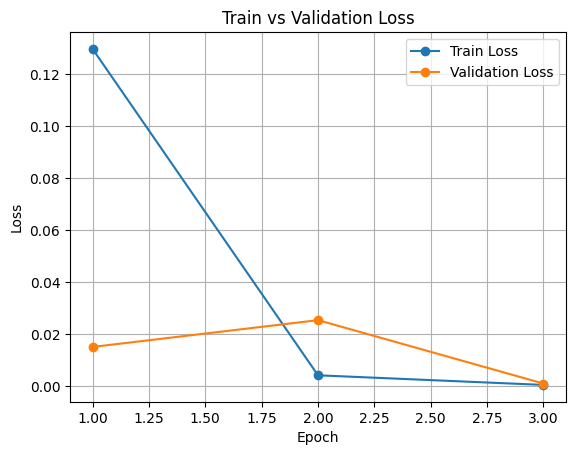

In [ ]:
plt.plot(train_df["epoch"], train_df["loss"], label="Train Loss", marker='o')
plt.plot(eval_df["epoch"], eval_df["eval_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


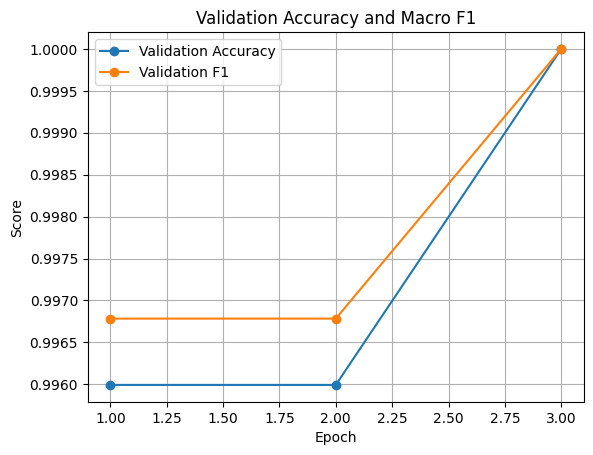

In [ ]:
plt.plot(eval_df["epoch"], eval_df["eval_accuracy"], label="Validation Accuracy", marker='o')
plt.plot(eval_df["epoch"], eval_df["eval_macro_f1"], label="Validation F1", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy and Macro F1")
plt.legend()
plt.grid(True)
plt.show()


The loss curves show a clear convergence during training. Training loss drops significantly from 0.1296 to 0.0004 by the third epoch, while validation loss begins low at 0.0150, slightly increases in the second epoch to 0.0253, and then drops again to 0.0009. This minor spike in validation loss could be due temporary noise or slight overfitting, but the sharp drop in the final epoch suggests the model corrected itself and continued improving.

The validation accuracy and macro F1 score remain high throughout training, around 0.996 and reaching a perfect 1.000 by epoch 3. This shows the model is achieving near-perfect classification performance. While this is excellent if the dataset is large and varied, it may also show that the dataset is too simple or repetitive (it’s small). I am going to evaluate the model on test set in the next step.

In [ ]:
trainer.evaluate(test_dataset)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.019295280799269676,
 'eval_accuracy': 0.9959919839679359,
 'eval_macro_precision': 0.9976771196283392,
 'eval_macro_recall': 0.9959595959595959,
 'eval_macro_f1': 0.9968019785092955,
 'eval_runtime': 4.214,
 'eval_samples_per_second': 118.414,
 'eval_steps_per_second': 7.594,
 'epoch': 3.0}

Above result showes that our model generalizes well to the test set.

The metrics are consistent with what we saw on the validation set.

Macro F1 near 1.0 means that the model is treating all 3 authors fairly, not just focusing on the majority class.

In this step I want to try our model to classify the text ,either some text samples from other books of the Author (not included in our training set) or text created by a "text generator model" , That is trained on some books of author, other than our training set (I created this model in other project). I also changed the character names in the sample text,to make our model predict based on the style and context similarity, only.

In [ ]:
import torch

# Example input text
text = "Sarah was beginning to doubt whether she had a wish for him, and therefore a doubt of his staying. She was rather uneasy as to what the future might be; and when she did recover, it was found that Mr. Smit and Harriet had not spoken of it to each other for more than an hour, and that the doubt of being absent from the place had not affected her."

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the model's device
device = trainer.model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run prediction
with torch.no_grad():
    outputs = trainer.model(**inputs)
    predicted_class = outputs.logits.argmax(dim=1).item()

# Decode label
predicted_label = le.inverse_transform([predicted_class])[0]
print("Predicted Author:", predicted_label)



Predicted Author: austen


In [ ]:
# Example input text
text = "however, had not a thing good to say to her in the last couple of weeks, she could hardly imagine what she had been possible of; and the very next day was spent at Bath, where Mr. and Mrs. Brown were to meet, and to be joined by a very well-wishing Mrs. Maiden, a woman who had never been present at Partfield, but who had been very fortunate in being acquainted with Mr. Brown, and had an open mind to every thing."

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the model's device
device = trainer.model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run prediction
with torch.no_grad():
    outputs = trainer.model(**inputs)
    predicted_class = outputs.logits.argmax(dim=1).item()

# Decode label
predicted_label = le.inverse_transform([predicted_class])[0]
print("Predicted Author:", predicted_label)

Predicted Author: austen


In [ ]:
# Example input text
#text = "I love you more than word can wield the matter, Dearer than eyesight, space, and liberty, Beyond what can be valued, rich or rare, No less than life, with grace, health, beauty, honor; As much as child e’er loved, or father found; A love that makes breath poor and speech unable; Beyond all manner of so much I love you."
#text = "I am that merry wanderer of the night. I jest to Oberon and make him smile When I a fat and bean-fed horse beguile, Neighing in likeness of a filly foal: And sometimes lurk I in a gossip’s bowl, In very likeness of a roasted crab, And when she drinks, against her lips I bob And on her withered dewlap pour the ale."
text = "It is always simple to fall; there are an infinity of angles at which one falls, only one at which one stands. A man may fall by pride or by power or by wealth or by wine. He may fall by ambition or by laziness, by cruelty or by softness, by jealousy or by ignorance. But each of the thousand sins comes from a distinct failure to be upright. Evil always takes advantage of the infinite possibilities of error. Good is always the same. It is always humble, always quiet, always simple. That is why it is so hard to recognize"

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the model's device
device = trainer.model.device
inputs = {k: v.to(device) for k, v in inputs.items()}   # Loops through each key–value pair in the dictionary. Calls .to(device) on each tensor (e.g., moves them to GPU if device = "cuda:0"). Creates a new dictionary with all tensors on the same device as the model

# Run prediction
with torch.no_grad():
    outputs = trainer.model(**inputs)  # Dictionary Unpacking  >> equivalent to: outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
    predicted_class = outputs.logits.argmax(dim=1).item()

# Decode label
predicted_label = le.inverse_transform([predicted_class])[0]
print("Predicted Author:", predicted_label)

Predicted Author: chesterton


between 10 differet text samples I tried, only 2 prediction was not correct and both were texts from Shakespeare books. I guess this could be due to 1- less number of samples we had from Shakespeare compare to other Authors (austen         2812,
chesterton     1647, shakespeare     530) or 2- the variety of Shakespeare books like plays (Tragedies,Comedies, Histories), poems, and sonnets with different styles. My suggestion for improvement is adding more samples to dataset from different book categories.

### Questions
Answer the following questions in detail.

1. What is a Transformer model, and how does it differ fundamentally from recurrent neural networks (RNNs)?

Transformer models are a type of deep learning model designed to handle sequential data by using self-attention mechanisms to capture dependencies between input and output sequences.

difference from recurrent neural networks (RNNs)s:

Self-Attention Mechanism: Captures relationships between all tokens in a sequence, allowing for parallelization.

Scalability: Can handle longer sequences and larger datasets more efficiently than previous models like RNNs and LSTMs.

2. Explain the concept of self-attention and why it significantly improves NLP tasks.

self-attention or Scaled Dot-Product Attention: Computes attention scores between all pairs of tokens, that helps models to understand relationships between words or entities in a sentence, no matter where they appear.

This mechanism captures long-range dependencies by calculating attention between all words in the sequence and helping the model to look at the entire sequence at once. Unlike traditional models that process words one by one it helps the model to find which words are most relevant to each other helpful for tasks like translation or text generation.

3. Discuss why fine-tuning pretrained Transformer models is effective compared to training from scratch.

Performance Improvement when working with limited data: Fine-tuning often results in models that perform better than those trained from scratch, especially when working with limited data.

Time and Resource Efficiency: Fine-tuning generally requires less time and computational resources compared to training a model from scratch since it starts with pre-existing weights and architectures.

Transfer Learning: By leveraging pre-trained models, fine-tuning allows for transfer learning, where knowledge gained from one task can be applied to another, potentially unrelated task.

4. What is the difference between BERT and GPT models? Describe their key design differences and typical use cases.

GPT (Generative Pre-trained Transformer), is designed as an autoregressive model that predicts the next word in a sentence given all the previous words.
Here are some key features of GPT:

Autoregressive Nature: GPT is trained to predict the next word sequentially, making it highly effective for tasks that involve generating text, like content creation, story generation, and language translation.

Unidirectional Context: GPT only considers the previous words in the input for predictions, not what follows. This unidirectional approach is simpler but limits its effectiveness in understanding the full context of the input.

BERT: Bidirectional Encoder Representations from Transformers contrasts with GPT in that it is designed to derive deep bidirectional context from text by processing words in relation to all the other words in a sentence (rather than just the words that precede them). Here are the hallmarks of BERT:

Bidirectional Context: BERT's major innovation is its mechanism of "masked language modeling" (MLM), where some words are randomly masked, and the objective is to predict these masked words based on both left and right context, thus providing a deeper understanding of language structure and usage.

Non-Generative: Unlike GPT, BERT is not used for generating text but for tasks that require understanding the relationships and representations within text, such as sentiment analysis, question answering, and language inference.

5. Explain positional encoding in Transformer models and its importance.

Transformers process all tokens in parallel which speeds up training but they don’t naturally capture order of tokens. To address this issue positional encoding was introduced which adds information about each token's position in the sequence which helps model to understand relationships and order between tokens.

We usually use sine and cosine functions to generate positional encodings. These positional encodings are added element-wise to the word embeddings. The resulting vectors contain both semantic and positional information which allows the Transformer model to understand not only the meaning of each word but also its position in the sequence.

Positional encodings are important in Transformer models for several reasons:

Contextual Understanding: In natural language meaning of a word depends on its position hence helping model to understand these differences.

Better Generalization: It allows Transformer models to handle input sequences of different lengths which makes them more flexible for tasks like document summarization or question answering.

Preventing Symmetry Issues: Without positional encoding it considers token as same which causes issues but by using positional encoding tokens at different positions are treated differently which improves model’s ability to capture long-range dependencies.

6. What are some common evaluation metrics used for your chosen NLP task, and why?

For the task of author style classification, a multi-class text classification problem, common evaluation metrics include accuracy, precision, recall, and F1-score.

Accuracy measures the overall proportion of correct predictions and is useful when classes are balanced. However, in many NLP tasks where class imbalance can exist, accuracy alone may be misleading. Therefore, metrics like macro-averaged precision, recall, and F1-score are also used.

Macro-averaging treats all classes equally by computing the metric for each class and then averaging the results, ensuring that each author’s writing style is fairly evaluated regardless of how many samples belong to them. These metrics help assess how well the model distinguishes between the writing styles of different authors.

In my code, the compute_metrics function is used within the Hugging Face Trainer to calculate these metrics at the end of  each epoch. It extracts the predicted class labels from the model’s output logits and compares them to the ground truth labels using sklearn's accuracy_score and precision_recall_fscore_support. The use of average="macro" ensures that precision, recall, and F1-score are computed independently for each class (author) and then averaged, which is especially important when all classes are equally important. This evaluation method gives a good understanding of the model’s performance across all author categories.

7. Discuss potential drawbacks or limitations of Transformer models (e.g., computational complexity, data requirements).

Computational complexity: Transformers can be computationally expensive to train and use, especially for large models like GPT-3. This can be a major barrier to their deployment in real-world applications.

Overfitting: Transformers can easily overfit to the training data, especially if the data is small or not diverse enough. This can lead to poor generalization performance on unseen data.

Attention bias: Transformers rely on attention mechanisms to determine which parts of the input sequence are most relevant. However, these mechanisms can sometimes be biased, leading to suboptimal results.

Interpretability: Transformers can be difficult to interpret and understand, as they are trained end-to-end and do not have clear, interpretable intermediate representations like those produced by some other neural network architectures.

8. How does tokenization impact Transformer model performance, and what considerations are important during data preprocessing?

Cost Efficiency: Proper tokenization directly impacts computational requirements. Inefficient tokenization can increase token count directly translating to higher inference costs when using commercial AI APIs.

Quality of Results: The quality of embeddings affects virtually every downstream task in the systems. Better embeddings lead to more accurate search results, more relevant recommendations, and more natural language generation.

System Architecture: The choice of tokenization and embedding strategies influences our entire AI infrastructure, from storage requirements to processing pipelines.

Model Performance: Research shows that tokenization alone can impact model performance, while embedding quality can make or break specialized applications.

9. Provide at least two examples of real-world applications using Transformers outside of your chosen task.

One of the earliest and most impactful applications of Transformers is machine translation. Models like Google’s Transformer-based Neural Machine Translation (NMT) system like Google Translate have significantly improved the accuracy and fluency of translations.

text generation like GPT-3 and 4 capable of producing human-like text based on given prompts.

Molecule Transformer: Predicts chemical reactions and assists in identifying potential drug candidates. Transformers are being used to predict molecular properties and assist in drug discovery.


10. What future directions or improvements could further enhance Transformer models?

Improving Multimodal Capabilities:
Cross-modal Transformers: Integrating text, image, audio, and video into unified models expands their versatility.

Vision-Language Models: Transformers like PaliGemma and DeepSeek-VL2 are pushing boundaries in understanding and generating across modalities

Biologically Inspired Models:
Some researchers are exploring neural architectures that mimic brain-like processing, potentially leading to more adaptive and energy-efficient models.
